In [1]:
!pip install cmocean


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Option 1: Save and display each band individually
Potential no-data value detected: 0 (636480 pixels, 7.8%)
Saving individual band plots to: E:\RIT_Assignments\IMGS 589\Homework1\sentinel2_bands
Displaying each plot...
------------------------------------------------------------
Saved: ./sentinel2_bands\rochester_band_01_B1___Coastal_Aerosol.png


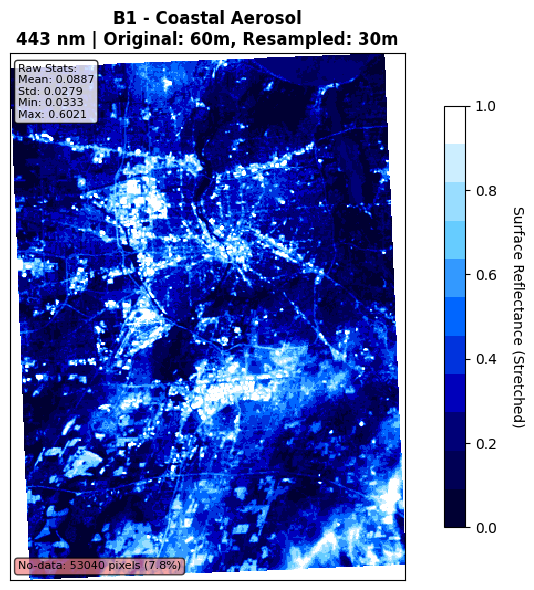

Saved: ./sentinel2_bands\rochester_band_02_B2___Blue.png


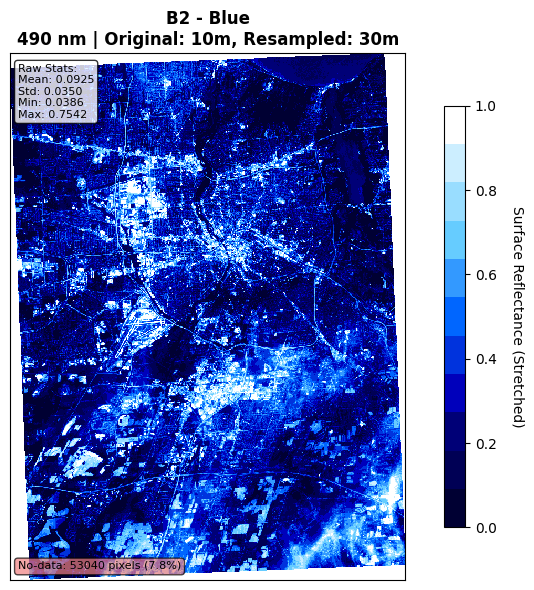

Saved: ./sentinel2_bands\rochester_band_03_B3___Green.png


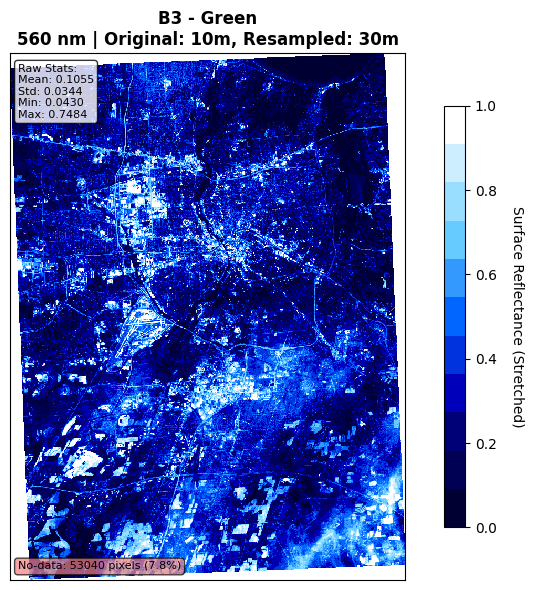

Saved: ./sentinel2_bands\rochester_band_04_B4___Red.png


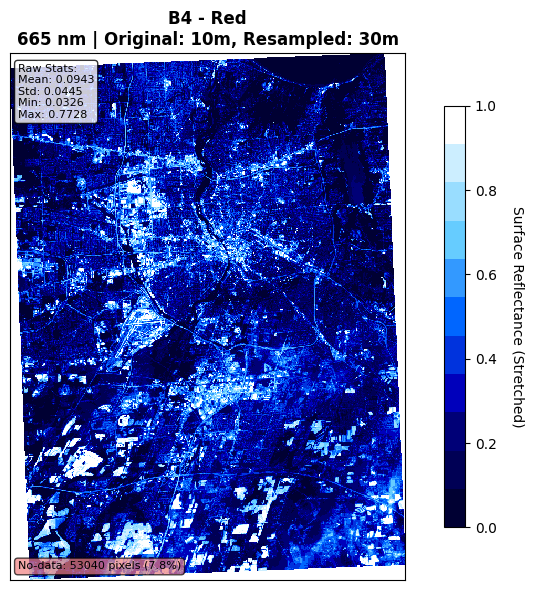

Saved: ./sentinel2_bands\rochester_band_05_B5___Red_Edge_1.png


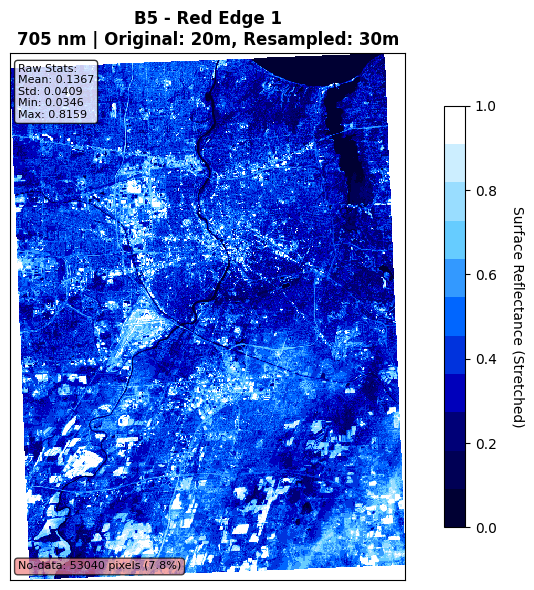

Saved: ./sentinel2_bands\rochester_band_06_B6___Red_Edge_2.png


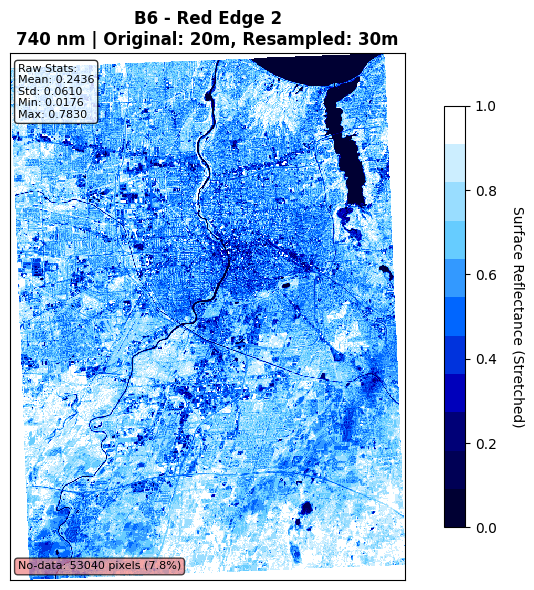

Saved: ./sentinel2_bands\rochester_band_07_B7___Red_Edge_3.png


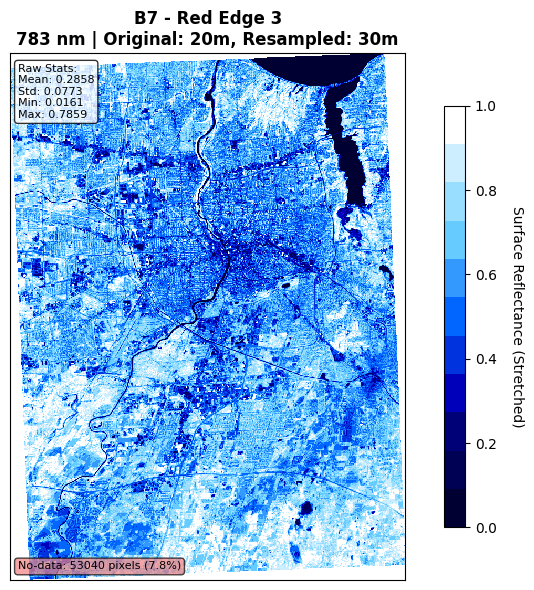

Saved: ./sentinel2_bands\rochester_band_08_B8___NIR.png


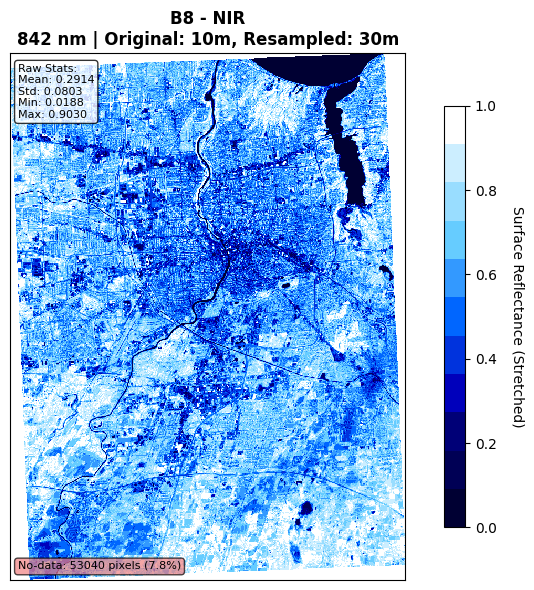

Saved: ./sentinel2_bands\rochester_band_09_B8A___Red_Edge_4.png


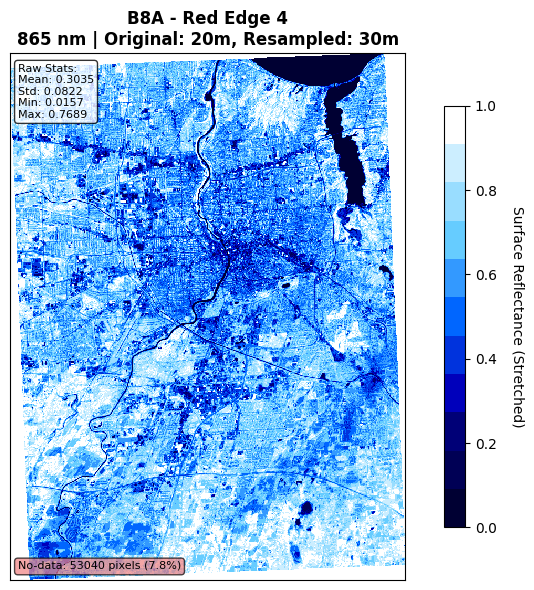

Saved: ./sentinel2_bands\rochester_band_10_B9___Water_Vapor.png


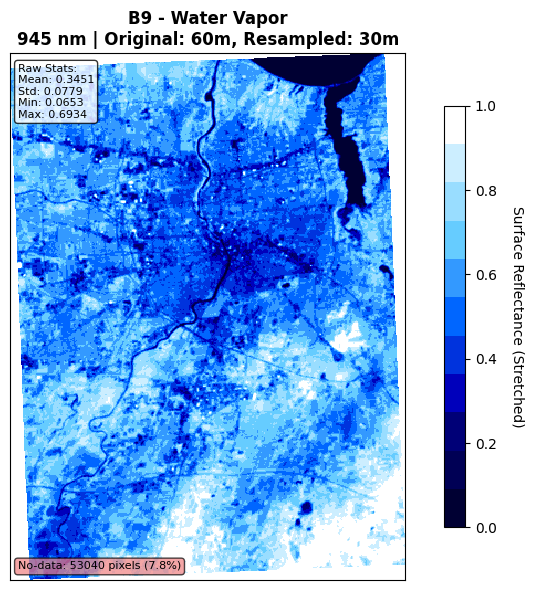

Saved: ./sentinel2_bands\rochester_band_11_B11___SWIR_1.png


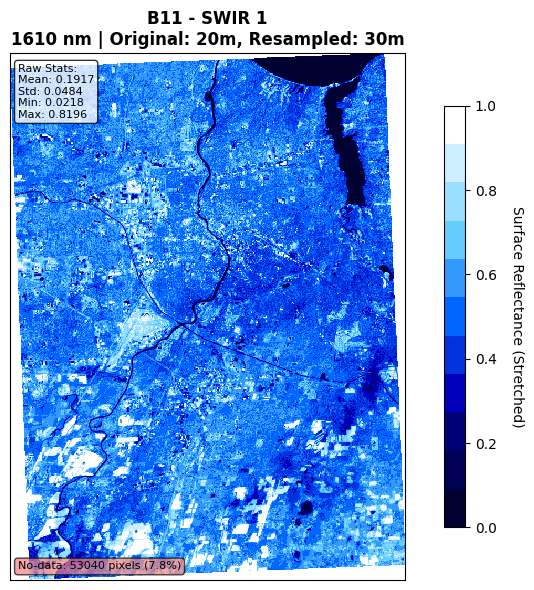

Saved: ./sentinel2_bands\rochester_band_12_B12___SWIR_2.png


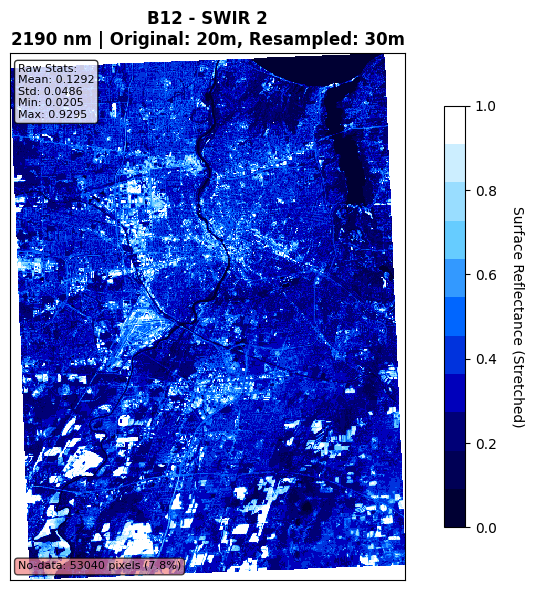

------------------------------------------------------------
Successfully saved 12 band images!

Displaying combined plot...
Potential no-data value detected: 0 (636480 pixels, 7.8%)
Saved combined plot: ./sentinel2_bands\sentinel2_all_bands_combined.png


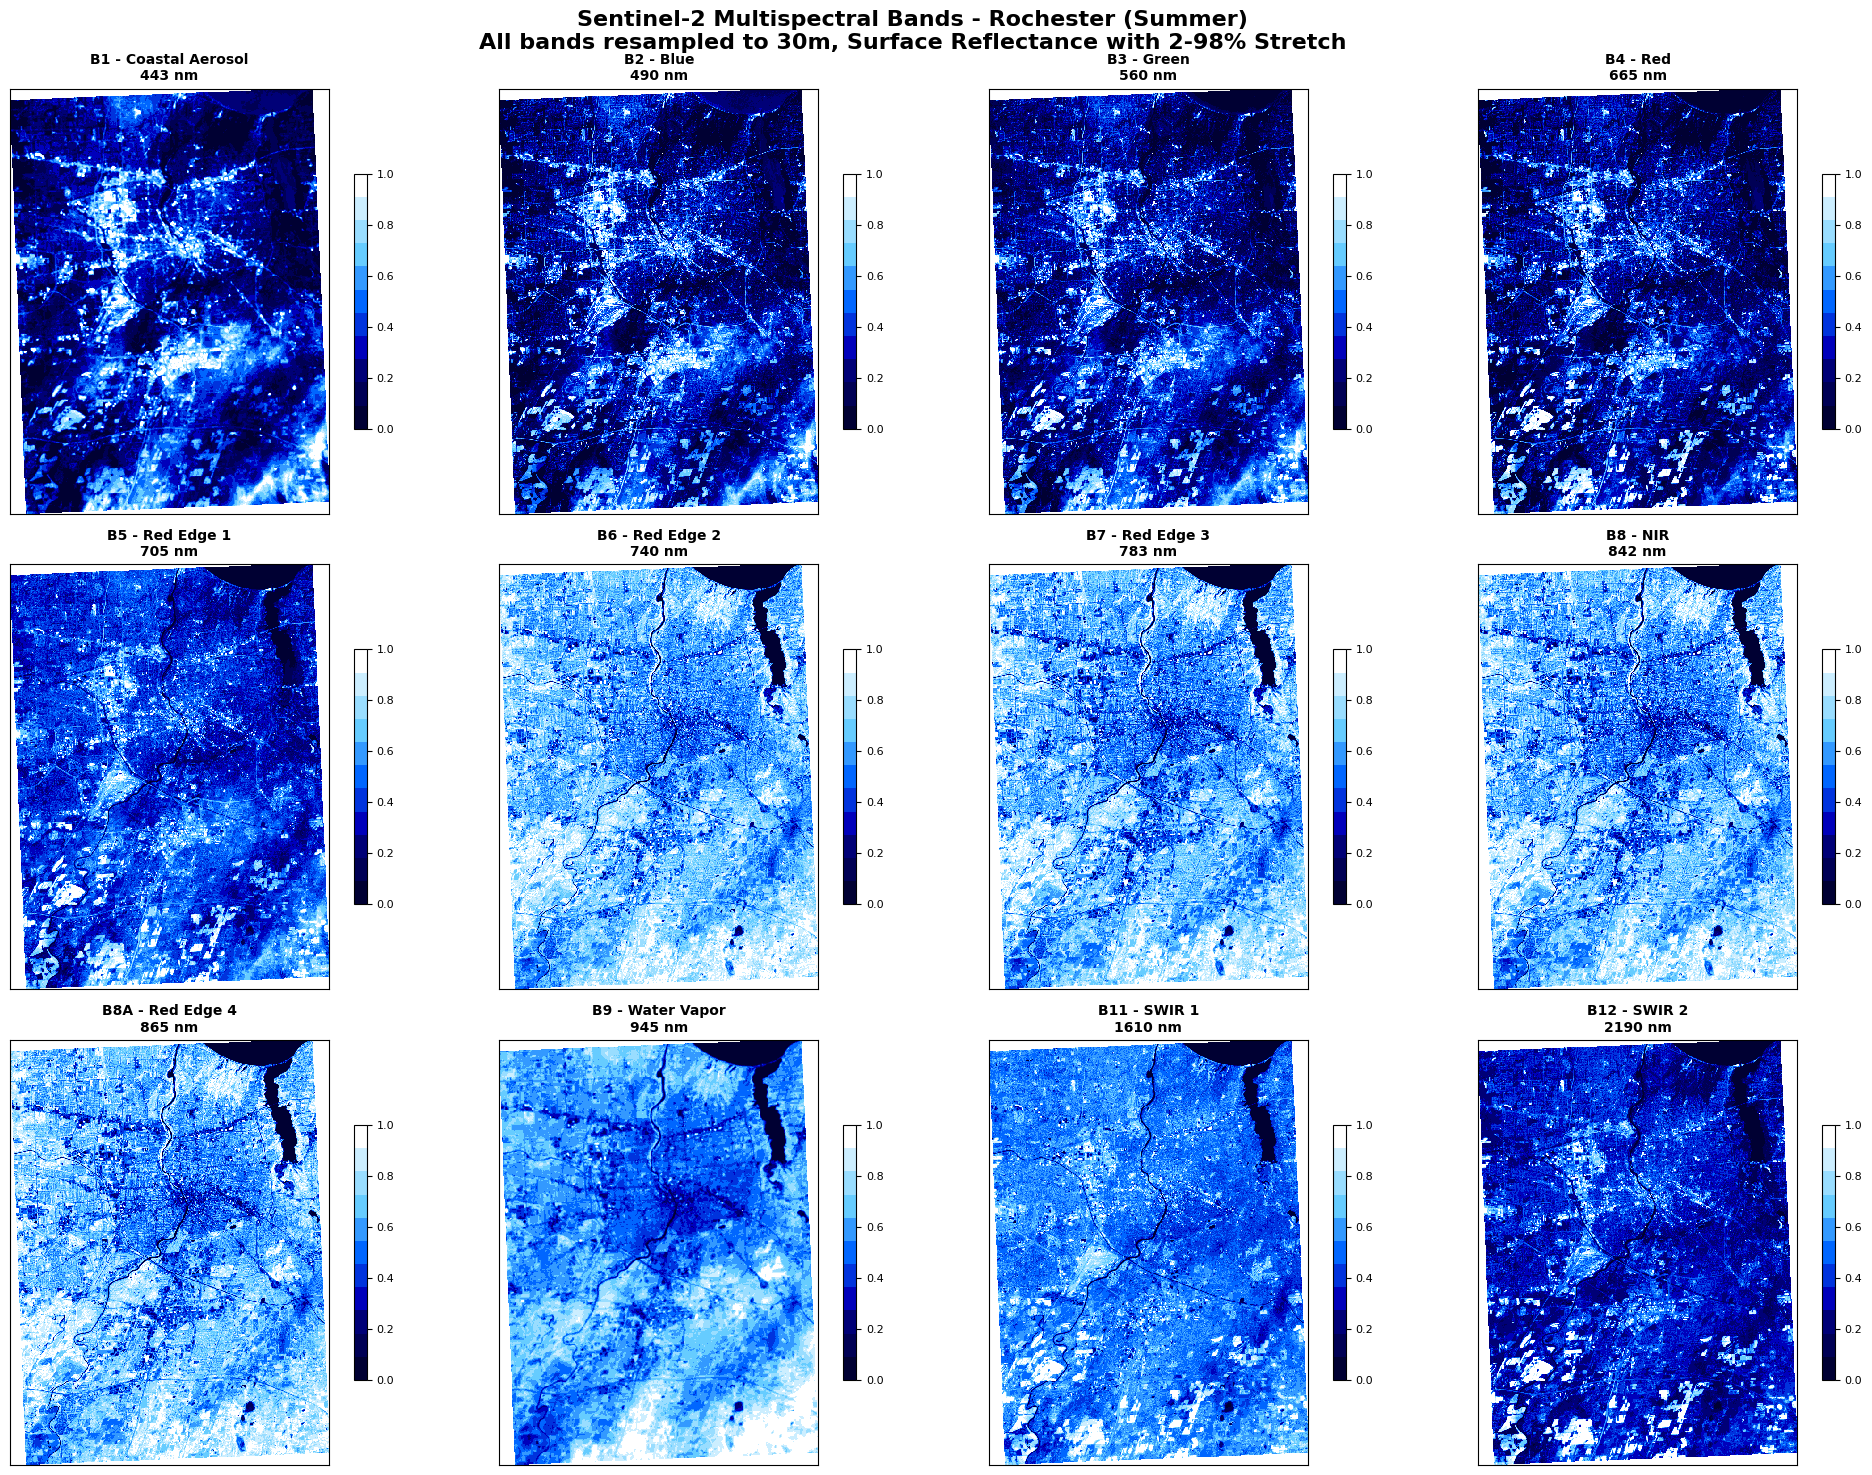


Saved files:
  - rochester_band_01_B1___Coastal_Aerosol.png
  - rochester_band_02_B2___Blue.png
  - rochester_band_03_B3___Green.png
  - rochester_band_04_B4___Red.png
  - rochester_band_05_B5___Red_Edge_1.png
  - rochester_band_06_B6___Red_Edge_2.png
  - rochester_band_07_B7___Red_Edge_3.png
  - rochester_band_08_B8___NIR.png
  - rochester_band_09_B8A___Red_Edge_4.png
  - rochester_band_10_B9___Water_Vapor.png
  - rochester_band_11_B11___SWIR_1.png
  - rochester_band_12_B12___SWIR_2.png


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import os

# Sentinel-2 band information
SENTINEL2_BANDS = {
    0: {'name': 'B1 - Coastal Aerosol', 'wavelength': '443 nm', 'resolution': '60m'},
    1: {'name': 'B2 - Blue', 'wavelength': '490 nm', 'resolution': '10m'},
    2: {'name': 'B3 - Green', 'wavelength': '560 nm', 'resolution': '10m'},
    3: {'name': 'B4 - Red', 'wavelength': '665 nm', 'resolution': '10m'},
    4: {'name': 'B5 - Red Edge 1', 'wavelength': '705 nm', 'resolution': '20m'},
    5: {'name': 'B6 - Red Edge 2', 'wavelength': '740 nm', 'resolution': '20m'},
    6: {'name': 'B7 - Red Edge 3', 'wavelength': '783 nm', 'resolution': '20m'},
    7: {'name': 'B8 - NIR', 'wavelength': '842 nm', 'resolution': '10m'},
    8: {'name': 'B8A - Red Edge 4', 'wavelength': '865 nm', 'resolution': '20m'},
    9: {'name': 'B9 - Water Vapor', 'wavelength': '945 nm', 'resolution': '60m'},
    10: {'name': 'B11 - SWIR 1', 'wavelength': '1610 nm', 'resolution': '20m'},
    11: {'name': 'B12 - SWIR 2', 'wavelength': '2190 nm', 'resolution': '20m'}
}

def create_cmocean_like_colormap():
    """Create a vibrant colormap similar to cmocean"""
    colors = ['#000033', '#000055', '#000077', '#0000BB', '#0033DD',
              '#0066FF', '#3399FF', '#66CCFF', '#99DDFF', '#CCEEFF', '#FFFFFF']
    return ListedColormap(colors, name='cmocean_like')

def robust_stretch(band, percentiles=(2, 98), no_data_value=0):
    # Create mask for valid data
    if no_data_value is not None:
        valid_mask = (band != no_data_value) & (~np.isnan(band)) & (band > 0)
    else:
        valid_mask = ~np.isnan(band)

    if not np.any(valid_mask):
        return band

    # Get valid data
    valid_data = band[valid_mask]

    # Calculate percentiles
    p_low, p_high = np.percentile(valid_data, percentiles)

    # Apply stretching
    stretched = np.copy(band).astype(float)
    stretched[valid_mask] = np.clip((band[valid_mask] - p_low) / (p_high - p_low), 0, 1)

    # Handle no-data areas
    if no_data_value is not None:
        stretched[band == no_data_value] = np.nan
        stretched[band <= 0] = np.nan

    return stretched

def detect_no_data_value(data):

    # Common no-data values to check
    candidates = [0, -9999, -32768, 65535, np.nan]

    for candidate in candidates:
        if np.isnan(candidate):
            count = np.sum(np.isnan(data))
        else:
            count = np.sum(data == candidate)

        # If more than 1% of pixels have this value, it might be no-data
        if count > 0.01 * data.size:
            print(f"Potential no-data value detected: {candidate} ({count} pixels, {count/data.size*100:.1f}%)")
            return candidate

    # Check for values that are exactly 0 (common for masked areas)
    zero_count = np.sum(data == 0)
    if zero_count > 0.05 * data.size:  # More than 5% zeros
        print(f"Using 0 as no-data value ({zero_count} pixels, {zero_count/data.size*100:.1f}%)")
        return 0

    return None

def clean_filename(text):
 
    # Replace spaces and special characters with underscores
    cleaned = text.replace(' ', '_').replace('-', '_').replace('/', '_')
    # Remove other problematic characters
    invalid_chars = '<>:"/\\|?*'
    for char in invalid_chars:
        cleaned = cleaned.replace(char, '')
    return cleaned

def plot_band(data, band_idx, no_data_value=None, figsize=(8, 6), cmap=None, save_path=None):

    if cmap is None:
        cmap = create_cmocean_like_colormap()

    # Extract the band
    band = data[:, :, band_idx].copy()

    # Auto-detect no-data if not specified
    if no_data_value is None:
        no_data_value = detect_no_data_value(band)

    # Apply robust stretching
    stretched_band = robust_stretch(band, percentiles=(2, 98), no_data_value=no_data_value)

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Display the band
    im = ax.imshow(stretched_band, cmap=cmap, interpolation='nearest')

    # Set title with band information
    band_info = SENTINEL2_BANDS[band_idx]
    title = f"{band_info['name']}\n{band_info['wavelength']} | Original: {band_info['resolution']}, Resampled: 30m"
    ax.set_title(title, fontsize=12, fontweight='bold')

    
    ax.set_xticks([])
    ax.set_yticks([])

    
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Surface Reflectance (Stretched)', rotation=270, labelpad=20)

    # Add statistics text
    valid_mask = ~np.isnan(stretched_band)
    if np.any(valid_mask):
        mean_val = np.mean(band[valid_mask])
        std_val = np.std(band[valid_mask])
        min_val = np.min(band[valid_mask])
        max_val = np.max(band[valid_mask])

        stats_text = f'Raw Stats:\nMean: {mean_val:.4f}\nStd: {std_val:.4f}\nMin: {min_val:.4f}\nMax: {max_val:.4f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=8)

    # Add no-data information
    if no_data_value is not None:
        no_data_count = np.sum(band == no_data_value)
        no_data_percent = no_data_count / band.size * 100
        no_data_text = f'No-data: {no_data_count} pixels ({no_data_percent:.1f}%)'
        ax.text(0.02, 0.02, no_data_text, transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
                fontsize=8)

    plt.tight_layout()
    
    # Save the figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    return fig, ax

def save_all_bands_individually(data, no_data_value=None, figsize=(8, 6), output_dir=".", prefix="sentinel2_band_", show_plots=True):
   
   
    if no_data_value is None:
        no_data_value = detect_no_data_value(data)

   
    os.makedirs(output_dir, exist_ok=True)
    
    saved_files = []
    
    print(f"Saving individual band plots to: {os.path.abspath(output_dir)}")
    if show_plots:
        print("Displaying each plot...")
    print("-" * 60)
    
    for i in range(12):
        # Get band information
        band_info = SENTINEL2_BANDS[i]
        
        # Create filename-safe title
        clean_band_name = clean_filename(band_info['name'])
        filename = f"{prefix}{i+1:02d}_{clean_band_name}.png"
        filepath = os.path.join(output_dir, filename)
        
        # Create and save the plot
        fig, ax = plot_band(data, band_idx=i, no_data_value=no_data_value, 
                           figsize=figsize, save_path=filepath)
        
       
        if show_plots:
            plt.show()
        
        
        plt.close(fig)
        
        saved_files.append(filepath)
    
    print("-" * 60)
    print(f"Successfully saved {len(saved_files)} band images!")
    
    return saved_files

def save_and_display_all_bands(data, no_data_value=None, figsize=(8, 6), output_dir=".", prefix="sentinel2_band_"):
  
    return save_all_bands_individually(data, no_data_value=no_data_value, figsize=figsize, 
                                     output_dir=output_dir, prefix=prefix, show_plots=True)

def plot_all_bands(data, no_data_value=None, figsize=(20, 15), save_combined=False, output_dir="."):
   
    cmap = create_cmocean_like_colormap()

    # Auto-detect no-data if not specified
    if no_data_value is None:
        no_data_value = detect_no_data_value(data)

    fig, axes = plt.subplots(3, 4, figsize=figsize)
    axes = axes.flatten()

    for i in range(12):
        band = data[:, :, i].copy()
        stretched_band = robust_stretch(band, percentiles=(2, 98), no_data_value=no_data_value)

        # Display the band
        im = axes[i].imshow(stretched_band, cmap=cmap, interpolation='nearest')

        # Set title
        band_info = SENTINEL2_BANDS[i]
        title = f"{band_info['name']}\n{band_info['wavelength']}"
        axes[i].set_title(title, fontsize=10, fontweight='bold')

        # Remove ticks
        axes[i].set_xticks([])
        axes[i].set_yticks([])

        # Add small colorbar
        cbar = plt.colorbar(im, ax=axes[i], shrink=0.6)
        cbar.ax.tick_params(labelsize=8)

    plt.suptitle('Sentinel-2 Multispectral Bands - Rochester (Summer)\nAll bands resampled to 30m, Surface Reflectance with 2-98% Stretch',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    # Save combined plot if requested
    if save_combined:
        combined_path = os.path.join(output_dir, "sentinel2_all_bands_combined.png")
        plt.savefig(combined_path, dpi=300, bbox_inches='tight')
        print(f"Saved combined plot: {combined_path}")
    
    return fig


if __name__ == "__main__":
    # Load your data
    data = np.load('sentinel2_rochester.npy')

    print("Option 1: Save and display each band individually")
    saved_files = save_and_display_all_bands(data, 
                                            output_dir="./sentinel2_bands",
                                            prefix="rochester_band_")

 
    print("\nDisplaying combined plot...")
    fig = plot_all_bands(data, save_combined=True, output_dir="./sentinel2_bands")
    plt.show()


    print(f"\nSaved files:")
    for file in saved_files:
        print(f"  - {os.path.basename(file)}")

In [ ]:
#Sentinel-2 satellite imagery of Rochester is processed and visualized by this code, which produces plots for each of the 12 spectral bands (from shortwave infrared to coastal blue).  When handling no-data, it automatically looks for common no-data values (such as 0, -9999, or NaN) by determining whether they occur in more than 1% to 5% of pixels. 
#It then generates masks to keep these invalid values out of color stretching and statistical computations.  To prevent missing satellite data from distorting the image contrast or statistics of actual surface reflectance values, the `robust_stretch` function applies 2-98% percentile stretching only to valid pixels while setting no-data areas to NaN so they appear as transparent gaps in the final visualizations.